<!--
Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
-->

# Overview

This tutorial demonstrates the basic capabilities of the [`AutoGP`](@ref) package.

In [1]:
import AutoGP

In [2]:
import CSV
import Dates
import DataFrames

using PyPlot: plt

## Loading Data

The first step is to load a dataset from disk. The [`tsdl.161.csv`](assets/tsdl.161.csv) file, obtained from the [Time Series Data Library](https://pkg.yangzhuoranyang.com/tsdl/), has two columns:

- `ds` indicates time stamps.
- `y` indicates measured time series values.

In the call to `CSV.File`, we explicitly set the type of the `ds` column to `Dates.Date`, permitted types for time indexes are types `T <: Real` and `T < :Dates.TimeType`, see [`AutoGP.IndexType`](@ref).

In [3]:
data = CSV.File("assets/tsdl.161.csv"; header=[:ds, :y], types=Dict(:ds=>Dates.Date, :y=>Float64));
df = DataFrames.DataFrame(data)
show(df)

     │ ds          y
─────┼───────────────────
   1 │ 1949-01-01  112.0
   2 │ 1949-02-01  118.0
   3 │ 1949-03-01  132.0
   4 │ 1949-04-01  129.0
   5 │ 1949-05-01  121.0
   6 │ 1949-06-01  135.0
   7 │ 1949-07-01  148.0
   8 │ 1949-08-01  148.0
   9 │ 1949-09-01  136.0
  10 │ 1949-10-01  119.0
  11 │ 1949-11-01  104.0
  12 │ 1949-12-01  118.0
  ⋮  │     ⋮         ⋮
 134 │ 1960-02-01  391.0
 135 │ 1960-03-01  419.0
 136 │ 1960-04-01  461.0
 137 │ 1960-05-01  472.0
 138 │ 1960-06-01  535.0
 139 │ 1960-07-01  622.0
 140 │ 1960-08-01  606.0
 141 │ 1960-09-01  508.0
 142 │ 1960-10-01  461.0
 143 │ 1960-11-01  390.0
 144 │ 1960-12-01  432.0
         121 rows omitted

We next split the data into a training set and test set.

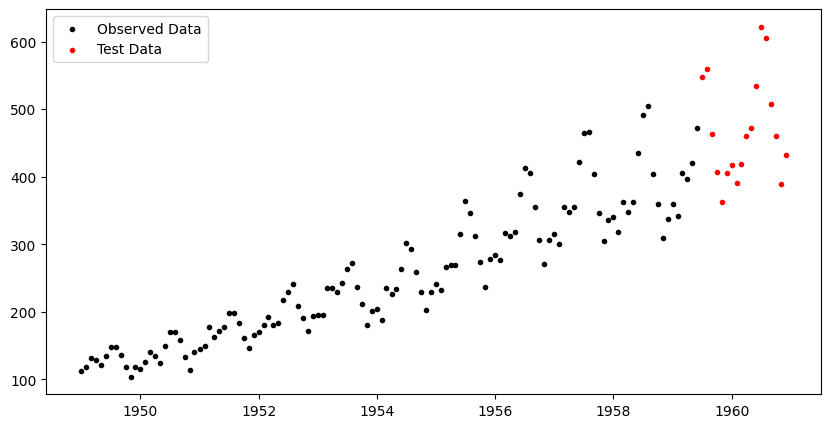

In [4]:
n_test = 18
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
ax.legend();

## Creating an AutoGP Model

Julia natively supports multiprocessing, which greatly improves performance for embarrassingly parallel computations in `AutoGP`. The number of threads available to Julia can be set using the `JULIA_NUM_THREADS=[nthreads]` environment variable or invoking `julia -t [nthreads]` from the command line.

In [5]:
Threads.nthreads()

8

We next initialize a [`AutoGP.GPModel`](@ref), which will enable us to automatically discover an ensemble of [Gaussian process covariance kernels](@ref gp_cov_kernel) for modeling the time series data. Initially, the model structures and parameters are sampled from the prior.  The `n_particles` argument is optional and specifices the number of particles for [sequential Monte Carlo inference](#Fitting-the-Model-using-Sequential-Monte-Carlo).

In [6]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=6);

## Generating Prior Forecasts

Calling [`AutoGP.covariance_kernels`](@ref) returns the ensemble of covariance kernel structures and parameters, whose weights are given by [`AutoGP.particle_weights`](@ref). These model structures have not yet been fitted to the data, so we are essentially importance sampling the posterior over structures and parameters given data by using the prior distribution as the proposal.

In [7]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    Base.display(k)
end

Model 1, Weight 0.26142074394894477


CP(0.19055667126219877, 0.001)
├── LIN(1.26; 3.19, 0.06)
└── PER(0.11, 0.52; 0.13)


Model 2, Weight 4.0257929388061755e-27


LIN(0.09; 0.52, 0.20)


Model 3, Weight 1.7975106803349286e-9


PER(1.37, 0.30; 1.04)


Model 4, Weight 1.1645819463329054e-21


GE(0.42, 1.00; 0.04)


Model 5, Weight 7.24814391228416e-39


×
├── GE(0.09, 0.54; 1.82)
└── PER(0.18, 0.14; 0.42)


Model 6, Weight 0.7385792542535452


GE(0.13, 0.29; 0.11)


Forecasts are obtained using [`AutoGP.predict`](@ref), which takes in a `model`, a list of time points `ds` (which we specify to be the observed time points, the test time points, and 36 months of future time points). We also specify a list of `quantiles` for obtaining prediction intervals. The return value is a [`DataFrames.DataFrame`](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrame) object that show the particle id, particle weight, and predictions from each of the particles in `model`.

In [8]:
ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=36)
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
show(forecasts)

      │ ds          particle  weight    y_0.025   y_0.975  y_mean
──────┼────────────────────────────────────────────────────────────
    1 │ 1949-01-01         1  0.261421  -83.3461  347.688  132.171
    2 │ 1949-02-01         1  0.261421  -83.1647  347.645  132.24
    3 │ 1949-03-01         1  0.261421  -83.0097  347.615  132.303
    4 │ 1949-04-01         1  0.261421  -82.8478  347.592  132.372
    5 │ 1949-05-01         1  0.261421  -82.7009  347.579  132.439
    6 │ 1949-06-01         1  0.261421  -82.5592  347.576  132.508
    7 │ 1949-07-01         1  0.261421  -82.4319  347.583  132.575
    8 │ 1949-08-01         1  0.261421  -82.3105  347.6    132.645
    9 │ 1949-09-01         1  0.261421  -82.1993  347.627  132.714
   10 │ 1949-10-01         1  0.261421  -82.1016  347.664  132.781
   11 │ 1949-11-01         1  0.261421  -82.0108  347.711  132.85
   12 │ 1949-12-01         1  0.261421  -81.9328  347.767  132.917
  ⋮   │     ⋮          ⋮         ⋮         ⋮         ⋮        ⋮


Let us visualize the forecasts before model fitting. The model clearly underfits the data.

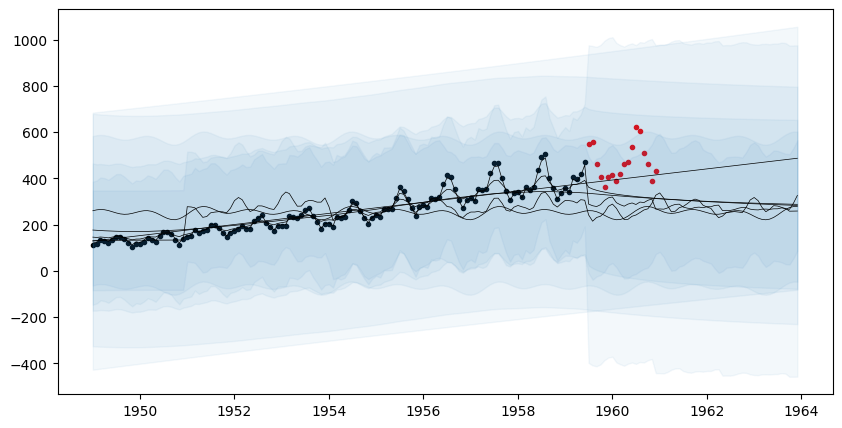

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end

## Model Fitting via SMC

The next step is to fit the model to the observed data. There are [three fitting algorithms](@ref end_to_end_model_fitting) available.  We will use [`AutoGP.fit_smc!`](@ref) which leverages sequential Monte Carlo structure learning to infer the covariance kernel structures and parameters.

The annealing schedule below adds roughly 10% of the observed data at each step, with 100 MCMC rejuvenation steps over the structure and 10 Hamiltonian Monte Carlo steps for the parameters. Using `verbose=true` will print some statistics about the acceptance rates of difference MCMC and HMC moves that are performed within the SMC learning algorithm.

In [10]:
AutoGP.seed!(6)
AutoGP.fit_smc!(model; schedule=AutoGP.Schedule.linear_schedule(n_train, .10), n_mcmc=75, n_hmc=10, verbose=true);

Running SMC round 13/126
weights [2.14e-01, 5.85e-02, 2.05e-01, 5.23e-01, 1.09e-04, 1.51e-04]
resampled true
accepted MCMC[12/75] HMC[71/78]
accepted MCMC[9/75] HMC[64/69]
accepted MCMC[19/75] HMC[122/132]
accepted MCMC[22/75] HMC[121/136]
accepted MCMC[22/75] HMC[89/107]
accepted MCMC[27/75] HMC[191/202]
Running SMC round 26/126
weights [8.08e-03, 4.24e-01, 1.10e-03, 1.92e-02, 3.97e-01, 1.50e-01]
resampled true
accepted MCMC[7/75] HMC[55/58]
accepted MCMC[6/75] HMC[37/40]
accepted MCMC[6/75] HMC[43/47]
accepted MCMC[12/75] HMC[52/60]
accepted MCMC[18/75] HMC[84/97]
accepted MCMC[21/75] HMC[112/125]
Running SMC round 39/126
weights [1.99e-02, 1.74e-01, 3.01e-02, 4.08e-02, 1.95e-02, 7.16e-01]
resampled true
accepted MCMC[0/75] HMC[0/0]
accepted MCMC[1/75] HMC[6/7]
accepted MCMC[5/75] HMC[43/44]
accepted MCMC[13/75] HMC[50/61]
accepted MCMC[10/75] HMC[64/71]
accepted MCMC[17/75] HMC[95/105]
Running SMC round 52/126
weights [1.66e-03, 8.13e-02, 8.69e-02, 1.65e-01, 4.54e-02, 6.20e-01]
resa

## Generating Posterior Forecasts

Having the fit data, we can now inspect the ensemble of posterior structures, parameters, and predictions.

In [11]:
ds_future = range(start=df_test.ds[end]+Dates.Month(1), step=Dates.Month(1), length=36)
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);
show(forecasts)

      │ ds          particle  weight    y_0.025   y_0.975   y_mean
──────┼─────────────────────────────────────────────────────────────
    1 │ 1949-01-01         1  0.518786   95.7778   124.096  109.937
    2 │ 1949-02-01         1  0.518786  105.533    132.895  119.214
    3 │ 1949-03-01         1  0.518786  118.461    145.764  132.113
    4 │ 1949-04-01         1  0.518786  112.317    139.654  125.985
    5 │ 1949-05-01         1  0.518786  106.34     133.628  119.984
    6 │ 1949-06-01         1  0.518786  118.932    146.186  132.559
    7 │ 1949-07-01         1  0.518786  131.405    158.626  145.016
    8 │ 1949-08-01         1  0.518786  132.641    159.89   146.266
    9 │ 1949-09-01         1  0.518786  122.15     149.355  135.753
   10 │ 1949-10-01         1  0.518786  104.155    131.338  117.746
   11 │ 1949-11-01         1  0.518786   92.5327   119.705  106.119
   12 │ 1949-12-01         1  0.518786  102.479    129.31   115.894
  ⋮   │     ⋮          ⋮         ⋮         ⋮    

The plot below reflects posterior uncertainty as to whether the linear componenet will persist or the data will revert to the mean.

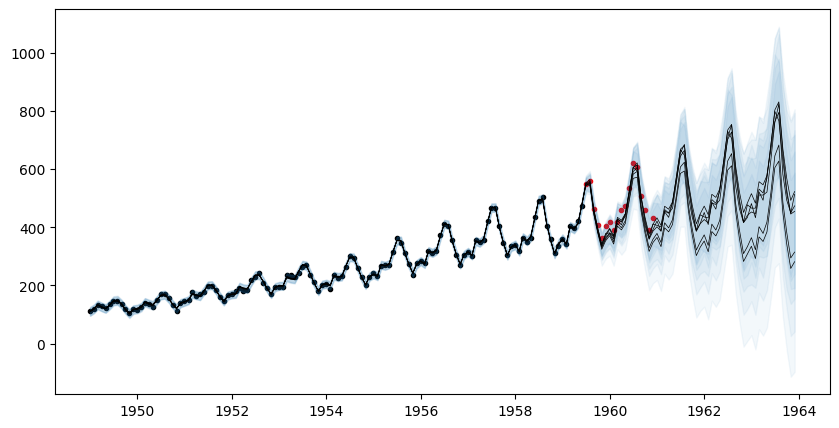

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_train.ds, df_train.y, marker=".", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")

for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end

We can also inspect the discovered kernel structures and their weights.

In [13]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

Model 1, Weight 0.5187856913664618


＋
├── ×
│   ├── LIN(0.58; 0.56, 0.19)
│   └── ＋
│       ├── LIN(0.19; 0.92, 0.79)
│       └── ×
│           ├── LIN(0.05; 0.02, 0.38)
│           └── ＋
│               ├── PER(0.78, 0.10; 0.20)
│               └── GE(0.72, 1.43; 0.11)
└── ×
    ├── LIN(0.16; 0.55, 0.51)
    └── ×
        ├── LIN(0.06; 0.16, 0.08)
        └── LIN(0.22; 0.07, 0.46)


Model 2, Weight 0.0388018393363426


×
├── LIN(0.38; 0.08, 0.92)
└── ＋
    ├── ×
    │   ├── LIN(0.58; 0.13, 0.07)
    │   └── GE(0.56, 1.51; 0.69)
    └── ×
        ├── LIN(0.05; 0.10, 0.70)
        └── PER(0.48, 0.10; 0.17)


Model 3, Weight 0.05854237186951741


×
├── LIN(0.06; 0.12, 0.55)
└── ＋
    ├── LIN(0.06; 0.83, 0.20)
    └── ×
        ├── LIN(0.05; 0.03, 0.37)
        └── ＋
            ├── PER(0.35, 0.10; 0.13)
            └── GE(0.58, 1.50; 0.20)


Model 4, Weight 0.12171996350432317


×
├── LIN(0.07; 0.12, 0.50)
└── ＋
    ├── ×
    │   ├── LIN(0.07; 0.08, 0.19)
    │   └── GE(0.56, 1.51; 0.69)
    └── ×
        ├── LIN(0.30; 0.13, 0.27)
        └── PER(0.48, 0.10; 0.17)


Model 5, Weight 0.09967934632668538


×
├── LIN(0.33; 0.08, 0.84)
└── ＋
    ├── ×
    │   ├── LIN(0.40; 0.13, 0.07)
    │   └── GE(0.69, 1.28; 0.33)
    └── ×
        ├── LIN(0.26; 0.10, 0.30)
        └── ＋
            ├── PER(0.54, 0.10; 0.14)
            └── LIN(0.52; 0.59, 0.21)


Model 6, Weight 0.16247078759667166


×
├── LIN(0.31; 0.12, 0.32)
└── ＋
    ├── ×
    │   ├── LIN(0.22; 0.21, 0.23)
    │   └── ＋
    │       ├── ×
    │       │   ├── LIN(0.30; 0.24, 0.92)
    │       │   └── LIN(0.10; 1.53, 0.25)
    │       └── ＋
    │           ├── GE(0.23, 1.25; 0.06)
    │           └── LIN(0.04; 0.34, 0.08)
    └── ×
        ├── LIN(0.38; 0.28, 0.27)
        └── PER(0.48, 0.10; 0.17)


## Computing Predictive Probabilities

In addition to generating forecasts, the predictive probability of new data can be computed by using [`AutoGP.predict_proba`](@ref). The table below shows that the particles in our collection are able to predict the future data with varying accuracy, illustrating the benefits of maintaining an ensemble of learned structures.

In [14]:
logps = AutoGP.predict_proba(model, df_test.ds, df_test.y);
show(logps)

   │ particle  weight     logp
───┼───────────────────────────────
 1 │        1  0.518786   -81.0226
 2 │        2  0.0388018  -80.4687
 3 │        3  0.0585424  -78.3537
 4 │        4  0.12172    -79.2853
 5 │        5  0.0996793  -79.5163
 6 │        6  0.162471   -77.2665

It is also possible to directly access the underlying predictive distribution of new data at arbitrary time series values by using [`AutoGP.predict_mvn`](@ref), which returns an instance of [`Distributions.MixtureModel`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.MixtureModel). The [`Distributions.MvNormal`](https://juliastats.org/Distributions.jl/stable/multivariate/#Distributions.MvNormal) object corresponding to each of the 7 particles in the mixture can be extracted using [`Distributions.components`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.components-Tuple{AbstractMixtureModel}) and the weights extracted using [`Distributions.probs`](https://juliastats.org/Distributions.jl/stable/mixture/#Distributions.probs-Tuple{AbstractMixtureModel}).

Each `MvNormal` in the mixture has 18 dimensions corresponding to the lenght of `df_test.ds`.

In [15]:
mvn = AutoGP.predict_mvn(model, df_test.ds)

MixtureModel{Distributions.MvNormal}(K = 6)
components[1] (prior = 0.5188): FullNormal(
dim: 18
μ: [550.0466055631144, 543.5685832436789, 458.0672732626237, 387.83042059450264, 336.3274841090669, 378.84360283044555, 380.7405954069613, 370.5597600287218, 428.60605677444596, 417.8272939610252, 445.710229207111, 527.722968622132, 606.5232420193234, 592.7113473338969, 495.58143177869687, 415.9744653512393, 361.6811541092175, 410.86491959299735]
Σ: [110.43133996791498 70.43337927366102 … 106.0193369583544 105.68013071952048; 70.43337927366102 157.2315611083291 … 175.7899821967875 176.06414206239037; … ; 106.0193369583544 175.7899821967875 … 1289.6029024068575 1266.7465844069018; 105.68013071952048 176.06414206239037 … 1266.7465844069018 1402.6718895178888]
)

components[2] (prior = 0.0388): FullNormal(
dim: 18
μ: [550.0896881260433, 557.9183559988504, 451.7397701335289, 387.6936971300408, 330.34991142470057, 359.2956794851918, 378.39571104805384, 350.04141045569975, 413.64406521435524, 398.

Operations from the [`Distributions`](https://juliastats.org/Distributions.jl) package can now be applied to the `mvn` object.

## Incorporating New Data

Online learning is supported by using [`AutoGP.add_data!`](@ref), which lets us incorporate a new batch of observations.  Each particle's weight will be updated based on how well it predicts the new data (technically, the predictive probability it assigns to the new observations). Before adding new data, let us first look at the current particle weights.

In [16]:
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 0.5187856913664618
 0.0388018393363426
 0.05854237186951741
 0.12171996350432317
 0.09967934632668538
 0.16247078759667166

Here are the forecasts and predictive probabilities of the test data under each particle in `model`.

In [17]:
using Printf: @sprintf

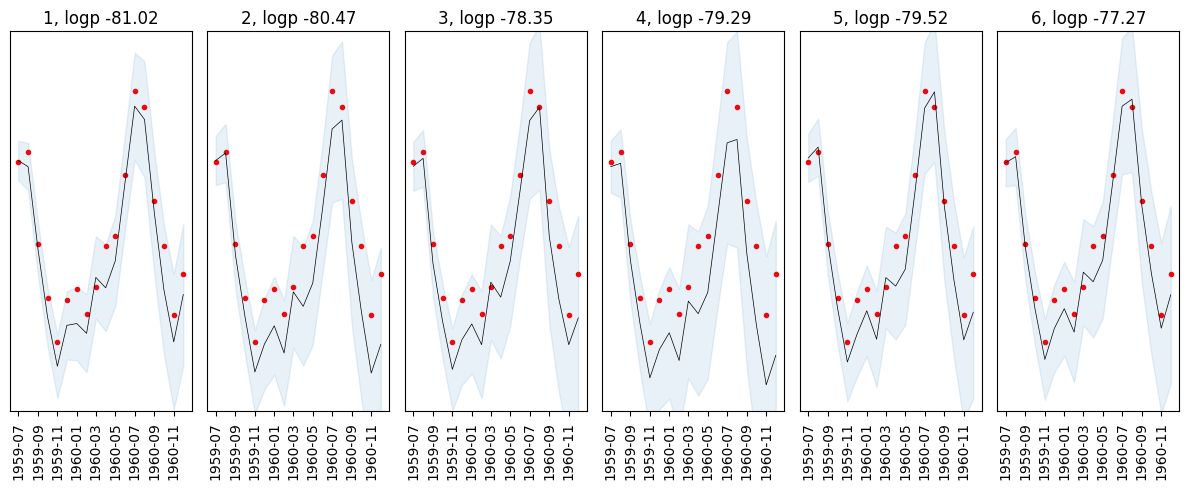

In [18]:
forecasts = AutoGP.predict(model, df_test.ds; quantiles=[0.025, 0.975])

fig, axes = plt.subplots(ncols=6)
for i=1:AutoGP.num_particles(model)
    axes[i].scatter(df_test.ds, df_test.y, marker=".", color="r", label="Test Data")
    subdf = forecasts[forecasts.particle.==i,:]
    axes[i].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    axes[i].fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.1)
    axes[i].set_title("$(i), logp $(@sprintf "%1.2f" logps[i,:logp])")
    axes[i].set_yticks([])
    axes[i].set_ylim([0.8*minimum(df_test.y), 1.1*maximum(df_test.y)])
    axes[i].tick_params(axis="x", labelrotation=90)
fig.set_size_inches(12, 5)
fig.set_tight_layout(true)
end

Now let's incorporate the data and see what happens to the particle weights.

In [19]:
AutoGP.add_data!(model, df_test.ds, df_test.y)
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 0.054480109584894444
 0.007089917054484329
 0.08867768509766472
 0.07262818579191704
 0.04720986321304457
 0.7299142392579898

The particle weights have changed to reflect the fact that some particles are able to predict the new data better than others, which indicates they are able to better capture the underlying data generating process.
The particles can be resampled using [`AutoGP.maybe_resample!`](@ref), we will use an effective sample size of `num_particles(model)/2` as the resampling criterion.

In [20]:
AutoGP.maybe_resample!(model, AutoGP.num_particles(model)/2)

true

Because the resampling critereon was met, the particles were resampled and now have equal weights.

In [21]:
AutoGP.particle_weights(model)

6-element Vector{Float64}:
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669
 0.16666666666666669

The estimate of the marginal likelihood can be computed using [`AutoGP.log_marginal_likelihood_estimate`](@ref).

In [22]:
AutoGP.log_marginal_likelihood_estimate(model)

214.57030788045827

Since we have added new data, we can update the particle structures and parameters by using [`AutoGP.mcmc_structure!`](@ref). Note that this "particle rejuvenation" operation does not impact the weights. 

In [23]:
AutoGP.mcmc_structure!(model, 100, 10; verbose=true)

accepted MCMC[19/100] HMC[0/38]
accepted MCMC[27/100] HMC[0/54]
accepted MCMC[23/100] HMC[0/46]
accepted MCMC[25/100] HMC[0/50]
accepted MCMC[26/100] HMC[0/52]
accepted MCMC[25/100] HMC[0/50]


Let's generate and plot the forecasts over the 36 month period again now that we have observed all the data. The prediction intervals are markedly narrower and it is more likely that the linear trend will persist rather than revert.

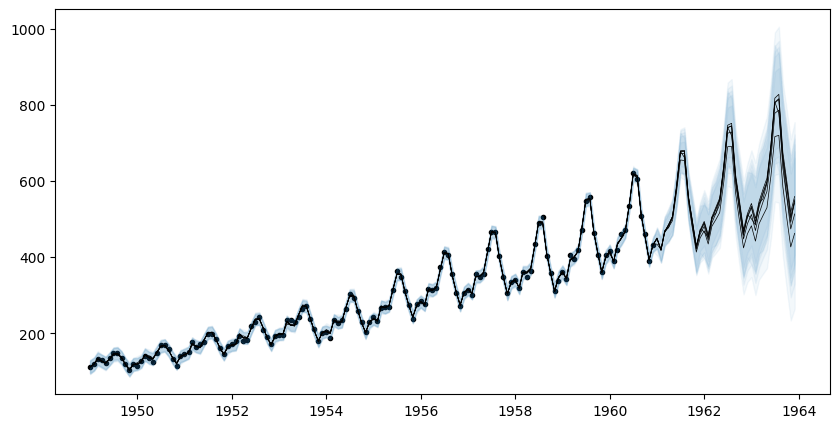

In [24]:
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df.ds, df.y, marker=".", color="k", label="Observed Data")
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end